<h3>Tutorial notebook for:</h3>

 - Loading selected datasets and models
 - Generating Global Counterfactual Explanations (GCEs) with GLOBE-CE and AReS
 - Comparing results

# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import urllib.request
from os import path
import time
import copy
from tqdm import tqdm
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
def bold(string):
    return '\033[1m' + string + '\033[0m'

# Select Dataset

In [3]:
from datasets import dataset_loader

In [4]:
name = 'german_credit'  # from compas, german_credit, default_credit, adult_income, heloc
dropped_features = []
dataset = dataset_loader(name, dropped_features=dropped_features, n_bins=None)

<strong> Do not normalise input data (GLOBE-CE will handle it) </strong>

<strong> Do not shuffle input data (ensures same train/test split and normalisation values) </strong>

In [5]:
x_train, y_train, x_test, y_test, x_means, x_std = dataset.get_split(normalise=False, shuffle=False,
                                                                     return_mean_std=True)
prop1s = round(np.average(y_train)*100, 2)
print(bold("Proportion of 1s in Training Data:") + " {}%".format(prop1s))

Proportion of 1s in Training Data: 70.12%


In [6]:
X = pd.DataFrame(x_train)
X.columns = dataset.features[:-1]
X_test = pd.DataFrame(x_test)
X_test.columns = dataset.features[:-1]
print(bold("Dataset:") + " {}\n".format(name.replace('_', ' ').title()))
X

Dataset: German Credit



,Existing-Account-Status = A11,Existing-Account-Status = A12,Existing-Account-Status = A13,Existing-Account-Status = A14,Month-Duration,Credit-History = A30,Credit-History = A31,Credit-History = A32,Credit-History = A33,Credit-History = A34,...,Job = A171,Job = A172,Job = A173,Job = A174,Num-People = 1,Num-People = 2,Telephone = A191,Telephone = A192,Foreign-Worker = A201,Foreign-Worker = A202
0,1,0,0,0,6,0,0,0,0,1,...,0,0,1,0,1,0,0,1,1,0
1,0,1,0,0,48,0,0,1,0,0,...,0,0,1,0,1,0,1,0,1,0
2,0,0,0,1,12,0,0,0,0,1,...,0,1,0,0,0,1,1,0,1,0
3,1,0,0,0,42,0,0,1,0,0,...,0,0,1,0,0,1,1,0,1,0
4,1,0,0,0,24,0,0,0,1,0,...,0,0,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,0,0,1,9,0,0,1,0,0,...,0,0,1,0,1,0,1,0,1,0
796,1,0,0,0,18,0,0,1,0,0,...,0,0,1,0,0,1,0,1,1,0
797,0,0,0,1,12,0,0,0,0,1,...,0,1,0,0,1,0,1,0,1,0
798,0,0,0,1,24,0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0


# Select Model

In [7]:
from models import performance

In [ ]:
B_name = 'lr'  # or 'lr' or 'xgb'
if B_name == 'dnn':
    from models import dnn_normalisers as normalisers
elif B_name == 'lr':
    from models import lr_normalisers as normalisers
else:  # no xgb normalisation
    normalisers = {name: False}
with open('models/{}_{}.pkl'.format(name, B_name), 'rb') as f:
    B = pickle.load(f)
normalise = [x_means, x_stds] if normalisers[name] else None

In [9]:
print(bold("Dataset:") + " {}".format(name.replace('_', ' ').title()))
print(bold("Model:") + " {}\n".format(B_name.replace('_', ' ').upper()))
performance(B, x_train, x_test, y_train, y_test, normalise=normalise)

Dataset: German Credit
Model: LR

Train Accuracy: 78.88%
Test Accuracy: 75.5%
Proportion of 1s Predicted (Train): 77.5%
Proportion of 1s Predicted (Test): 71.0%


# Global Evaluation Parameters

In [229]:
n_bins = 10
ordinal_features = []
dropped_features = []

# (Fast) AReS

<h3>Process:</h3>

 - <b>Import and initialise AReS</b>
 - <b>Generate itemsets</b>
     - SD and RL (lower threshold gives larger sets)
     - Or, for example, set affected_subgroup='Foreign-Worker=A201' (SD)
     - RL will then be generated with the provided threshold
 - <b>Generate ground set</b>
     - Lower performance with smaller SD and RL, but faster
     - For Fast AReS, either:
         - set RL_reduction=True
         - OR set RL_reduction=False and then_generation=threshold
     - a good then_generation threshold is the theoretical minimum, 1/|X|
     - the threshold used to generate SD and RL would then have to be higher
     - then_generation seems to perform better on continuous datasets
     - combining RL_reduction with then_generation doesn't seem to perform well
 - <b>Evaluate ground set (for AReS, evaluate the whole ground set)</b>
     - Set plot_accuracy=True
     - Set save_mode=0 and try varying r (a good starting point is r=1000)
     - Choose an optimal r value (normally once the accuracy plot plateaus)
     - Set save_mode=1 or save_mode=2
     - The former will save all r triples, the latter will only save the triples that increase the accuracy of the set as they are added i.e. the vertical blues lines in the accuracy plot)
     - <b>WARNING:</b> This will overwrite the initially large ground set
 - <b>Select the best triples from the ground set</b>
 - <b>Optimise the ground set</b>

In [230]:
from ares import Apriori, TwoLevelRecourseSet, AReS

In [231]:
ares = AReS(model=B, dataset=dataset, X=X, dropped_features=dropped_features,
            n_bins=n_bins, ordinal_features=ordinal_features,
            normalise=normalisers[name], constraints=[20,7,10])

In [232]:
ares.generate_itemsets(apriori_threshold=0.16, max_width=None, # defaults to e2-1
                       affected_subgroup=None, save_copy=True)

Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 2562 combinations | Sampling itemset size 64
SD and RL Computed with Lengths 2598 and 2598
Saving Copies of SD and RL as SD_copy and RL_copy


In [233]:
ares.generate_groundset(max_width=None, RL_reduction=True,
                        then_generation=None, save_copy=False)

Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 2598 to 1199


100%|██████████| 2598/2598 [01:19<00:00, 32.49it/s] 

Ground Set Computed with Length 1263950


4999it [00:06, 746.35it/s]


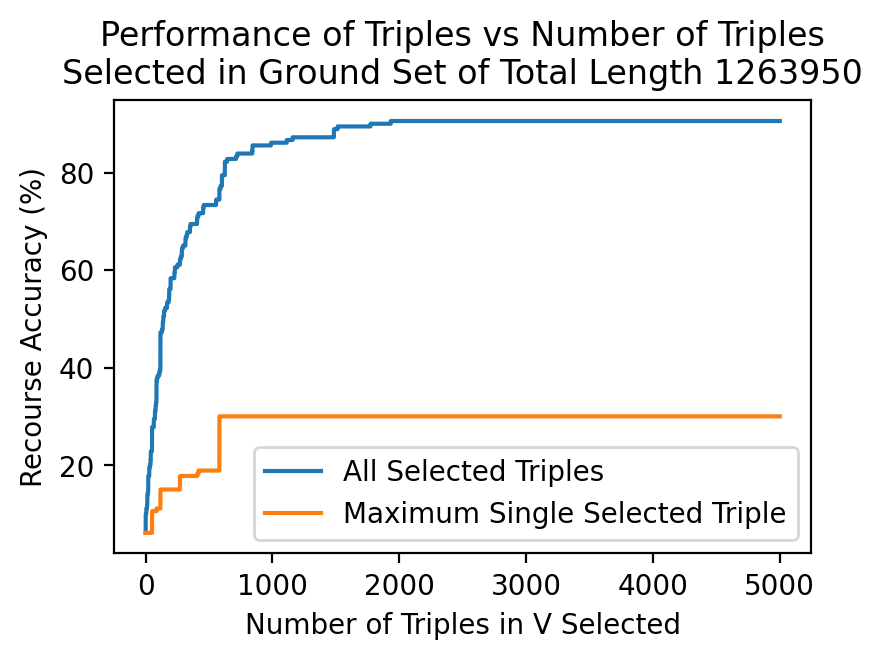

In [234]:
lams = [1, 1000]  # can play around with these lambda values
ares.evaluate_groundset(lams=lams, r=5000, save_mode=1,
                        disable_tqdm=False, plot_accuracy=True)

In [235]:
# this selects the s best triples according to objective
# can rerun- it's safe if you want to go back mid optimisation
# now that the optimise function runs so quickly
# you can probably just set s=r (the whole saved ground set)
ares.select_groundset(s=5000)

Candidate Set Filtered with Length: 5000


Initialising Copy of Ground Set
Ground Set Copied
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 4999/4999 [00:00<00:00, 98614.54it/s]


Checking Exchange


100%|██████████| 4983/4983 [00:01<00:00, 2970.74it/s]


Checking Delete
Checking Add


100%|██████████| 4983/4983 [00:00<00:00, 305773.30it/s]


Checking Exchange


100%|██████████| 4982/4982 [00:01<00:00, 3193.80it/s]


Checking Delete
Checking Add


100%|██████████| 4982/4982 [00:00<00:00, 296502.63it/s]


Checking Exchange


100%|██████████| 4982/4982 [00:01<00:00, 3263.89it/s]
17it [00:00, 851.76it/s]


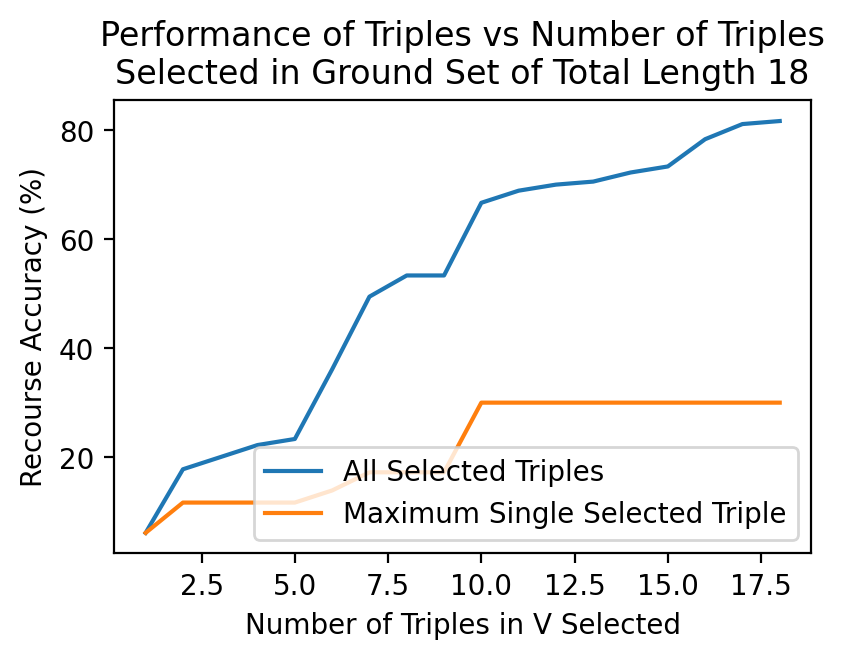

In [236]:
ares.optimise_groundset(lams=lams, factor=1, print_updates=False,
                        print_terms=False)

In [237]:
print(bold("Accuracy:") + " {}%".format(round(ares.R.accuracy, 2)))
# only inputs with positive counterfactual predictions
print(bold("Average Cost:") + " {}".format(round(ares.R.average_cost, 2)))

print(bold("\nAccuracy Upper Bound (Evaluated/Sorted Ground Set):")
      + " {}%".format(round(ares.V.accuracy, 2)))

costs_ares, corrects_ares = ares.accuracy_cost_bounds(ares.R.cost_vector)

Accuracy: 81.67%
Average Cost: 1.1

Accuracy Upper Bound (Evaluated/Sorted Ground Set): 90.56%


In [238]:
# clear the output to save space after running this cell
print(bold("Final {} Triples Post-Optimisation\n".format(ares.R.length)))
for triple in ares.R.triples:
    outer_ifs, inner_ifs, thens = [sorted([j for j in triple[i]]) for i in range(3)]
    print(bold("If") + " {}:".format(', '.join(outer_ifs)))
    print(bold("\t  If") + " {}".format(', '.join(inner_ifs)))
    print(bold("\tThen") + " {}\n".format(', '.join(thens)))

Final 18 Triples Post-Optimisation

If Foreign-Worker = A201, Installment = A143, Telephone = A191:
	  If Existing-Account-Status = A12, Housing = A152
	Then Existing-Account-Status = A14, Housing = A152

If Foreign-Worker = A201, Residence = 4:
	  If Existing-Account-Status = A12, Installment = A143
	Then Existing-Account-Status = A14, Installment = A143

If Housing = A152, Job = A173:
	  If Existing-Credits = 2, Foreign-Worker = A201, Num-People = 1, Savings-Account = A61
	Then Existing-Credits = 1, Foreign-Worker = A201, Num-People = 1, Savings-Account = A61

If Foreign-Worker = A201, Housing = A152:
	  If Existing-Credits = 2, Telephone = A191
	Then Existing-Credits = 1, Telephone = A192

If Foreign-Worker = A201, Housing = A152:
	  If Installment = A143, Residence = 2
	Then Installment = A143, Residence = 4

If Guarantors = A101, Sex = A93:
	  If Existing-Account-Status = A11, Foreign-Worker = A201, Savings-Account = A61
	Then Existing-Account-Status = A14, Foreign-Worker = A201, 

# GLOBE-CE

In [239]:
from globe_ce import GLOBE_CE

In [240]:
# AReS initiated to determine bin widths for costs- n_bins must be same as above
ares_widths = AReS(model=B, dataset=dataset, X=X, n_bins=n_bins, normalise=normalise)
bin_widths = ares_widths.bin_widths

In [241]:
# initialise GLOBE_CE
globe_ce = GLOBE_CE(model=B, dataset=dataset, X=X, affected_subgroup=None,
                    dropped_features=dropped_features, delta_init='zeros',
                    ordinal_features=ordinal_features, normalise=normalise,
                    bin_widths=bin_widths, monotonicity=None, p=1)

### Sample random $\delta$ vectors (translations)

100%|██████████| 2000/2000 [00:00<00:00, 2002.80it/s]


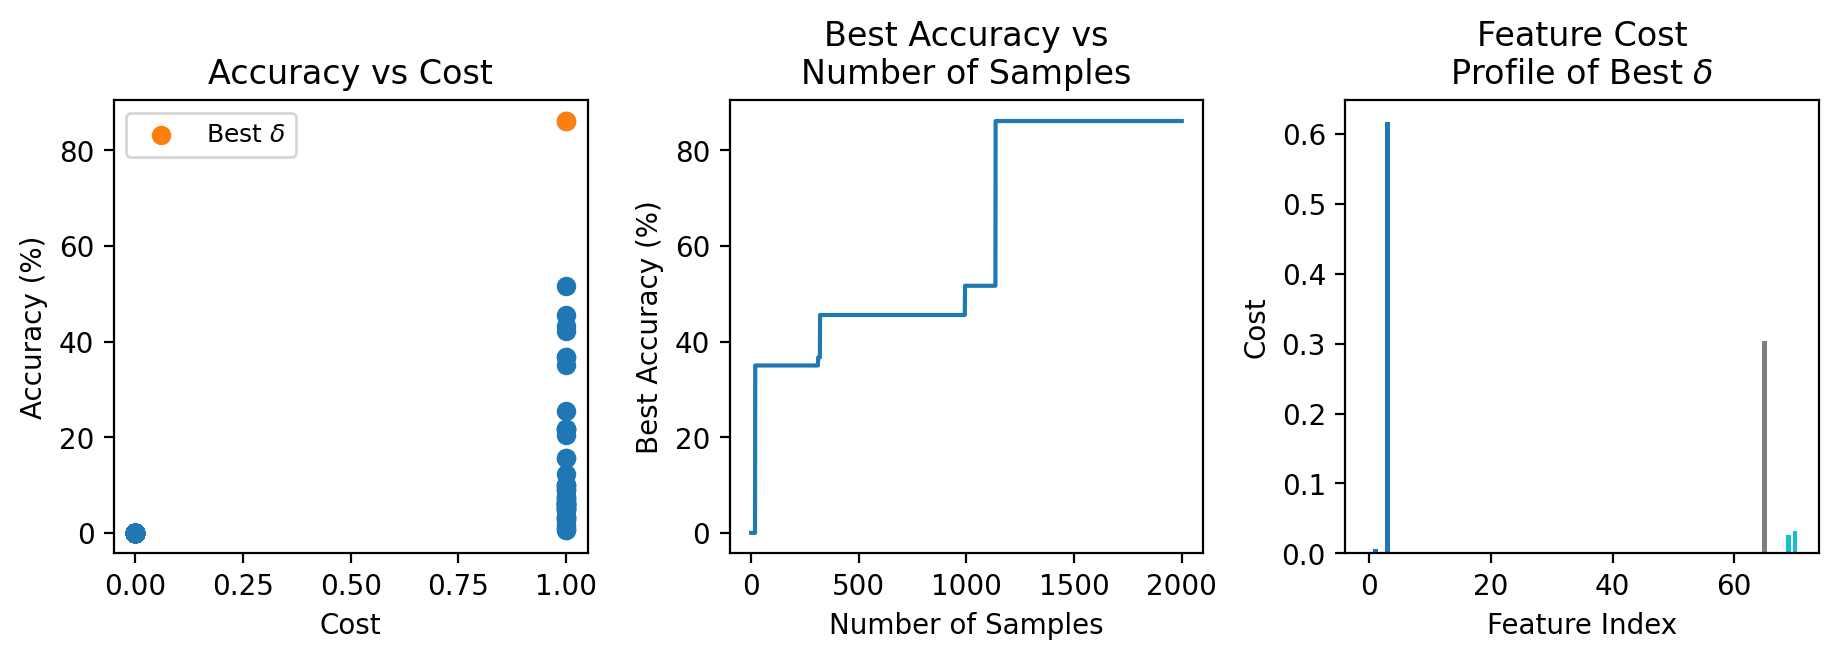

In [242]:
# note that the Cumulative Rules Chart (CRC) is possibly more
# intepretable without continuous features, and they also have
# little impact on the GCEs in this case, so we drop them
globe_ce.sample(n_sample=2000, magnitude=1, sparsity_power=5,  # magnitude is the fixed cost sampled at
                idxs=None, n_features=5, disable_tqdm=False,
                plot=True, seed=0, scheme='random',
                dropped_features=globe_ce.continuous_features)
delta = globe_ce.best_delta

### Scale best $\delta$ and Compute Minimum Costs/Scalars per Input

In [243]:
corrects, costs, scalars = globe_ce.scale(delta=delta, vector=True, plot=True)
min_costs = globe_ce.min_scalar_costs(costs=costs, return_idxs=False)

100%|██████████| 1000/1000 [00:00<00:00, 2094.70it/s]

Unable to find recourse for 9/180 inputs


### Compute Best Average Costs given each Input uses its Minimum Scalar

In [244]:
costs_bound, corrects_bound = globe_ce.accuracy_cost_bounds(min_costs)

### Cluster Scalars and Evaluate Rules

In [245]:
# n_bins bins the magnitudes equally, so n_bins=5 may return just 3 scalars
# (2 are duplicates i.e. different scalar but same rules)
# look in the paper for vector of lower bounds- a better implementation would
# just compute these values when working with categorical data
max_scalar_idxs = globe_ce.cluster_by_costs(costs, n_bins=5)
print(bold("Cumulative Rules Chart:"))
# can also produce a latex table with latex_table=True
costs_cluster, corrects_cluster = globe_ce.evaluate_clustering(delta, scalars, max_scalar_idxs, costs=costs, vector=True)

Cumulative Rules Chart:

 New Inputs:	+86.11%	New Inputs Cost:	1.0)
 Rules:	 Existing-Account-Status: If Not A14, Then A14
(Accuracy:	86.11%	Average Cost:		1.0)

 New Inputs:	+2.22%	New Inputs Cost:	1.5)
 Rules:	 Existing-Account-Status: If Not A14, Then A14
	 Num-People: If 2, Then 1
(Accuracy:	88.33%	Average Cost:		1.01)

 New Inputs:	+6.67%	New Inputs Cost:	2.08)
 Rules:	 Existing-Account-Status: If Not A14, Then A14
	 Num-People: If 2, Then 1
	 Foreign-Worker: If A201, Then A202
(Accuracy:	95.0%	Average Cost:		1.09)

Accuracy:	95.0%
Average Cost:	1.0877


### Accuracy-Cost Profiles and Minimum Costs Histogram

 - Here, the <b>"optimal"</b> accuracy-cost profile is the one for which the minimum cost is used for each individual input. The plot is then built by sorting each input by minimum cost and adding each input one by one
     - E.g. if the lowest cost (with correct recourse) was 1 in a group of 100 inputs, the first accuracy-cost plot point would be 1% accuracy at average cost 1. If the second and third lowest costs were also 1, the next points are 2% and 3% accuracy at average cost 1. If the fourth lowest cost was 2, the next point is 4% accuracy at average cost 1.25, etc, until the maximum accuracy is reached
 
 - The <b>"clustered"</b> profile is generated by selecting a limited number of scalars for which to evaluate recourses... may improve interpretability for categorical data though it's not reflective of the minimum costs per input

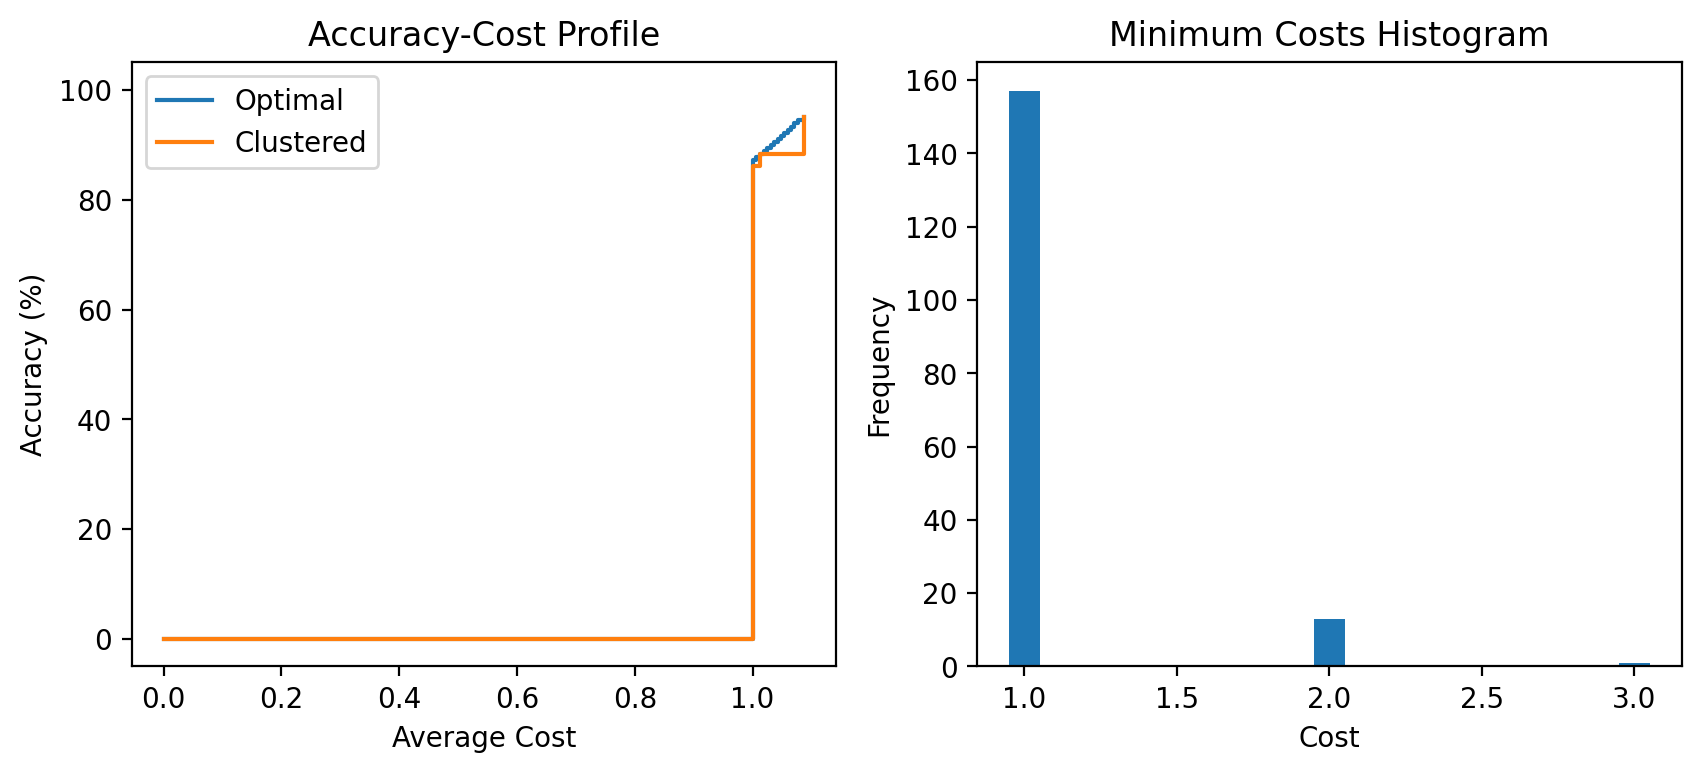

In [253]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200)
fig.set_figwidth(10)
ax[0].step(costs_bound, corrects_bound, where='post', label='Optimal')
ax[0].step(costs_cluster, corrects_cluster, where='post', label='Clustered')
ax[0].set_ylim([-5, 105])
ax[0].set_title('Accuracy-Cost Profile')
ax[0].set_xlabel('Average Cost')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()
ax[1].set_title('Minimum Costs Histogram')
width = 0.1
mins = min_costs[min_costs!=0]
# Using barplot since its easier
unique, count = np.unique(mins, return_counts=True)
ax[1].bar(unique, count, width=width)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Cost')
plt.show()

# Comparing GLOBE-CE to AReS

 - times can also be added by wrapping the code with:
 - start_time = time.time()
 - run AReS (or GLOBE-CE)
 - time_ares = time.time() - start_time

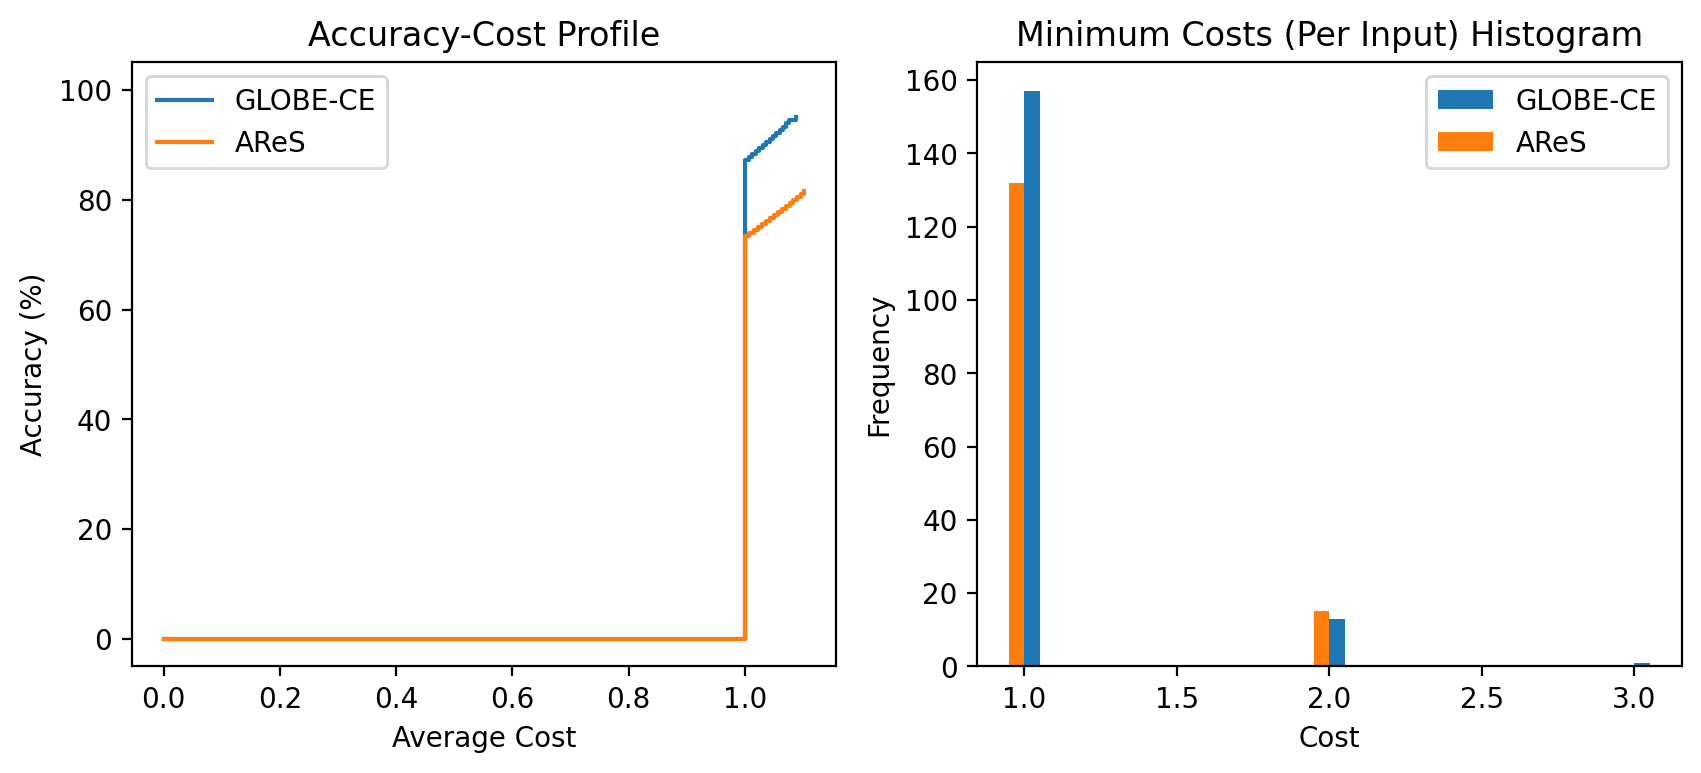

[GLOBE-CE]	Maximum Accuracy:			 95.0%
[GLOBE-CE]	Average Cost at Maximum Accuracy:	 1.09

[AReS]		Maximum Accuracy:			 81.67%
[AReS]		Average Cost at Maximum Accuracy:	 1.1


In [274]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200)
fig.set_figwidth(10)

ax[0].step(costs_bound, corrects_bound, where='post', label='GLOBE-CE')
ax[0].step(costs_ares, corrects_ares, where='post', label='AReS')
ax[0].set_ylim([-5, 105])
ax[0].set_title('Accuracy-Cost Profile')
ax[0].set_xlabel('Average Cost')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend()

ax[1].set_title('Minimum Costs (Per Input) Histogram')
width = 0.05
mins = min_costs[min_costs!=0]
unique, count = np.unique(mins, return_counts=True)
ax[1].bar(unique+width/2, count, width=width, label='GLOBE-CE')
mins_ares = ares.R.cost_vector[~np.isnan(ares.R.cost_vector)]
unique_ares, count_ares = np.unique(mins_ares, return_counts=True)
ax[1].bar(unique_ares-width/2, count_ares, width=width, label='AReS')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Cost')
ax[1].legend()

plt.show()

print(bold("[GLOBE-CE]\tMaximum Accuracy:\t\t\t") + " {}%".format(round(corrects_bound[-1], 2)))
# only inputs with positive counterfactual predictions
print(bold("[GLOBE-CE]\tAverage Minimum Cost at Maximum Accuracy:\t") + " {}".format(round(costs_bound[-1], 2)))

print(bold("\n[AReS]\t\tMaximum Accuracy:\t\t\t") + " {}%".format(round(ares.R.accuracy, 2)))
# only inputs with positive counterfactual predictions
print(bold("[AReS]\t\tAverage Minimum Cost at Maximum Accuracy:\t") + " {}".format(round(ares.R.average_cost, 2)))